<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import datetime as dt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

# I. EDA

In [2]:
# Load the data and get a look at the first 5 rows
df_house = pd.read_csv('housing.csv')
df_house.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Get the overall dimensions of the dataframe
df_house.shape

(1460, 81)

In [4]:
# Check columns datatype and see the non-numerical columns
# Start with the non-numerical columns for data cleanup
df_house.columns[df_house.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [5]:
# Check each of the columns and get an idea for the sample values for each
df_house[df_house.columns[df_house.isnull().any()].tolist()].sample(10)

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
1130,65.0,NaN,None,0.0,TA,TA,No,BLQ,Unf,SBrkr,TA,Detchd,1981.0,Unf,TA,TA,NaN,MnPrv,NaN
471,92.0,NaN,None,0.0,Gd,TA,No,Unf,Unf,SBrkr,Gd,Attchd,1977.0,RFn,TA,TA,NaN,NaN,NaN
720,NaN,NaN,None,0.0,Gd,TA,Gd,GLQ,Unf,SBrkr,TA,Attchd,1985.0,RFn,TA,TA,NaN,NaN,NaN
22,75.0,NaN,BrkFace,281.0,Gd,TA,No,Unf,Unf,SBrkr,Gd,Attchd,2002.0,RFn,TA,TA,NaN,NaN,NaN
758,24.0,Pave,BrkFace,360.0,Gd,TA,No,ALQ,Unf,SBrkr,NaN,Detchd,1999.0,Unf,TA,TA,NaN,NaN,NaN
1295,70.0,NaN,BrkFace,168.0,TA,TA,Av,BLQ,Unf,SBrkr,NaN,Attchd,1968.0,RFn,TA,TA,NaN,GdWo,NaN
1132,90.0,NaN,None,0.0,TA,TA,Mn,Unf,Unf,SBrkr,NaN,Detchd,1930.0,Unf,Fa,TA,NaN,NaN,NaN
834,75.0,NaN,BrkFace,136.0,TA,TA,No,Rec,Unf,SBrkr,NaN,Attchd,1961.0,Unf,TA,TA,NaN,GdWo,NaN
1056,43.0,NaN,Stone,240.0,Gd,TA,Av,GLQ,Unf,SBrkr,Gd,Attchd,2005.0,RFn,TA,TA,NaN,NaN,NaN
441,92.0,NaN,BrkFace,270.0,TA,TA,No,ALQ,Unf,FuseF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Create a list of default values for all columns with NaN
IMPUTE_COLUMNS = df_house.columns[df_house.isnull().any()].tolist()
IMPUTE_VALUES = [0,'NA','None',0,'NA','NA','NA','NA','NA','SBrkr','NA','NA',0,'NA','NA','NA','NA','NA','NA']

In [7]:
# Impute the default values on columns with NaN values
for key, value in dict(zip(IMPUTE_COLUMNS,IMPUTE_VALUES)).items():
    df_house[key].fillna(value, inplace=True)

In [8]:
# Re-check again
df_house.columns[df_house.isnull().any()]

Index([], dtype='object')

In [9]:
# Do some visualization, ADD LATER (INITIAL ASSUMPTIONS)

# II. FEATURE ENGINEERING FOR M1 AND M2

In [10]:
# Filter out all the non-residential records
# MSZoning: Identifies the general zoning classification of the sale.
#        A	Agriculture
#        C	Commercial
#        FV	Floating Village Residential
#        I	Industrial
#        RH	Residential High Density
#        RL	Residential Low Density
#        RP	Residential Low Density Park 
#        RM	Residential Medium Density
df_house_res = df_house[df_house['MSZoning'].isin(['FV', 'RH', 'RL', 'RP', 'RM'])]

In [11]:
# Group the related features together before visualization
F_FIXED = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','Utilities',
           'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt',
           'YearRemodAdd', 'Foundation','TotalBsmtSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
           'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea']
F_NFXED = ['OverallQual', 'OverallCond', 'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea',
           'ExterQual','ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
           'HeatingQC','CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
           'GarageQual','GarageCond','PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
           'PoolArea','PoolQC','Fence','MiscFeature','MiscVal']
F_SALES = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']

In [12]:
# Sale Conditions are excluded for both DataFrames of Model 1 and 2
# Create DataFrame for Model 1 (Fixed + Target Variable)
df_house_m1 = df_house_res[F_FIXED + ['SalePrice', 'YrSold']]
df_house_m1.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,FullBath,HalfBath,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice,YrSold
1032,60,RL,0.0,14541,Pave,NA,IR1,Lvl,AllPub,Corner,...,2,1,1,10,1,1993.0,3,796,310000,2006
751,60,RL,0.0,7750,Pave,NA,Reg,Lvl,AllPub,Inside,...,2,1,1,6,0,2003.0,2,400,162000,2007
904,20,RL,0.0,6173,Pave,NA,IR1,Lvl,AllPub,Inside,...,1,0,1,6,0,1967.0,1,288,125500,2007
21,45,RM,57.0,7449,Pave,Grvl,Reg,Bnk,AllPub,Inside,...,1,0,1,6,1,1930.0,1,280,139400,2007
1435,20,RL,80.0,8400,Pave,NA,Reg,Lvl,AllPub,Inside,...,1,1,1,7,1,1962.0,2,462,174000,2008


In [13]:
# Create DataFrame for Model 2 (Fixed + Non-Fixed + Target Variable)
df_house_m2 = df_house_res[F_FIXED + F_NFXED+ ['SalePrice', 'YrSold']]
df_house_m2.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SalePrice,YrSold
110,50,RL,75.0,9525,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,0,NA,NA,NA,0,136900,2006
613,20,RL,70.0,8402,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,0,NA,NA,NA,0,147000,2007
693,30,RL,60.0,5400,Pave,NA,Reg,Lvl,AllPub,Corner,...,112,0,0,0,NA,NA,NA,0,108480,2006
1451,20,RL,78.0,9262,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,0,NA,NA,NA,0,287090,2009
718,60,RL,96.0,10542,Pave,NA,Reg,Lvl,AllPub,Inside,...,216,0,0,0,NA,NA,NA,0,341000,2008


In [14]:
# Feature Engineering - Calculate Age of the Building
df_house_m1['Age'] = dt.date.today().year - df_house_m1['YearBuilt']
df_house_m2['Age'] = dt.date.today().year - df_house_m2['YearBuilt']

/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# Feature Engineering - Remodeled Flag (Y/N)
df_house_m1['Remodel'] = np.where(df_house_m1['YearBuilt'] == df_house_m1['YearRemodAdd'], 0, 1)
df_house_m2['Remodel'] = np.where(df_house_m2['YearBuilt'] == df_house_m2['YearRemodAdd'], 0, 1)

/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Feature Engineering - Calculate Age of the Garage
df_house_m1['AgeGarage'] = np.where(df_house_m1['GarageYrBlt'] == 0, 0, dt.date.today().year - df_house_m1['GarageYrBlt'])
df_house_m2['AgeGarage'] = np.where(df_house_m2['GarageYrBlt'] == 0, 0, dt.date.today().year - df_house_m2['GarageYrBlt'])

/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
df_house_m1.drop(columns=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], inplace=True)
df_house_m2.drop(columns=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], inplace=True)

/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [18]:
# Get Dummy Variables except Condition 2
# Get the Dummy Variables for all except Condition 1 and 2 since these 2 columns have overlapping values 
df_house_m1 = pd.get_dummies(data=df_house_m1, columns=['MSSubClass','MSZoning','Street', 'Alley','LotShape',
                                                        'LandContour','Utilities','LotConfig','LandSlope',
                                                        'Neighborhood','Condition1','BldgType','HouseStyle',
                                                        'Foundation'], drop_first=True)

df_house_m2 = pd.get_dummies(data=df_house_m2, columns=['MSSubClass','MSZoning','Street', 'Alley','LotShape',
                                                        'LandContour','Utilities','LotConfig','LandSlope',
                                                        'Neighborhood','Condition1','BldgType','HouseStyle',
                                                        'RoofStyle','RoofMatl', 'Exterior1st', 'MasVnrType', 
                                                        'Foundation','Heating','Electrical','GarageType', 'MiscFeature'],
                             drop_first=True)

In [19]:
#Iterate through Condition2 and map to the dummy variables of Condition1 except Artery which has been dropped
for index, row in df_house_m1.iterrows():
    if row['Condition2'] == 'Feedr':
        df_house_m1.at[index, 'Condition1_Feedr'] = 1
    elif row['Condition2'] == 'Norm':
        df_house_m1.at[index, 'Condition1_Norm'] = 1
    elif row['Condition2'] == 'PosA':
        df_house_m1.at[index, 'Condition1_PosA'] = 1
    elif row['Condition2'] == 'PosN':
        df_house_m1.at[index, 'Condition1_PosN'] = 1
    elif row['Condition2'] == 'RRAe':
        df_house_m1.at[index, 'Condition1_RRAe'] = 1
    elif row['Condition2'] == 'RRAn':
        df_house_m1.at[index, 'Condition1_RRAn'] = 1
    elif row['Condition2'] == 'RRNe':
        df_house_m1.at[index, 'Condition1_RRNe'] = 1
    elif row['Condition2'] == 'RRNn':
        df_house_m1.at[index, 'Condition1_RRNn'] = 1
        
for index, row in df_house_m2.iterrows():
    if row['Condition2'] == 'Feedr':
        df_house_m2.at[index, 'Condition1_Feedr'] = 1
    elif row['Condition2'] == 'Norm':
        df_house_m2.at[index, 'Condition1_Norm'] = 1
    elif row['Condition2'] == 'PosA':
        df_house_m2.at[index, 'Condition1_PosA'] = 1
    elif row['Condition2'] == 'PosN':
        df_house_m2.at[index, 'Condition1_PosN'] = 1
    elif row['Condition2'] == 'RRAe':
        df_house_m2.at[index, 'Condition1_RRAe'] = 1
    elif row['Condition2'] == 'RRAn':
        df_house_m2.at[index, 'Condition1_RRAn'] = 1
    elif row['Condition2'] == 'RRNe':
        df_house_m2.at[index, 'Condition1_RRNe'] = 1
    elif row['Condition2'] == 'RRNn':
        df_house_m2.at[index, 'Condition1_RRNn'] = 1

In [20]:
df_house_m1.drop(columns=['Condition2'], inplace=True)
df_house_m2.drop(columns=['Condition2'], inplace=True)

In [21]:
#Iterate through Exterior2nd and map to the dummy variables of Exterior1st except AsbShng which has been dropped
for index, row in df_house_m2.iterrows():
    if row['Exterior2nd'] == 'AsphShn':
        df_house_m2.at[index, 'Exterior1st_AsphShn'] = 1
    elif row['Exterior2nd'] == 'BrkComm':
        df_house_m2.at[index, 'Exterior1st_BrkComm'] = 1
    elif row['Exterior2nd'] == 'BrkFace':
        df_house_m2.at[index, 'Exterior1st_BrkFace'] = 1
    elif row['Exterior2nd'] == 'CBlock':
        df_house_m2.at[index, 'Exterior1st_CBlock'] = 1
    elif row['Exterior2nd'] == 'CemntBd':
        df_house_m2.at[index, 'Exterior1st_CemntBd'] = 1
    elif row['Exterior2nd'] == 'HdBoard':
        df_house_m2.at[index, 'Exterior1st_HdBoard'] = 1
    elif row['Exterior2nd'] == 'ImStucc':
        df_house_m2.at[index, 'Exterior1st_ImStucc'] = 1
    elif row['Exterior2nd'] == 'MetalSd':
        df_house_m2.at[index, 'Exterior1st_MetalSd'] = 1
    elif row['Exterior2nd'] == 'Other':
        df_house_m2.at[index, 'Exterior1st_Other'] = 1
    elif row['Exterior2nd'] == 'Plywood':
        df_house_m2.at[index, 'Exterior1st_Plywood'] = 1
    elif row['Exterior2nd'] == 'PreCast':
        df_house_m2.at[index, 'Exterior1st_PreCast'] = 1
    elif row['Exterior2nd'] == 'Stone':
        df_house_m2.at[index, 'Exterior1st_Stone'] = 1
    elif row['Exterior2nd'] == 'Stucco':
        df_house_m2.at[index, 'Exterior1st_Stucco'] = 1
    elif row['Exterior2nd'] == 'VinylSd':
        df_house_m2.at[index, 'Exterior1st_VinylSd'] = 1
    elif row['Exterior2nd'] == 'Wd Sdng':
        df_house_m2.at[index, 'Exterior1st_Wd Sdng'] = 1
    elif row['Exterior2nd'] == 'WdShing':
        df_house_m2.at[index, 'Exterior1st_WdShing'] = 1

In [22]:
df_house_m2.drop(columns=['Exterior2nd'], inplace=True)

In [23]:
# Encode remaining features for df_house_m2
dict_ExterQual = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
dict_ExterCond = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
dict_BsmtQual = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
dict_BsmtCond = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
dict_BsmtExposure = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
dict_BsmtFinType1 = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}
dict_BsmtFinType2 = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}
dict_HeatingQC = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
dict_CentralAir = {'Y':1, 'N':0}
dict_KitchenQual = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
dict_Functional = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
dict_FireplaceQu = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
dict_GarageFinish = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
dict_GarageQual = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
dict_GarageCond = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
dict_PavedDrive = {'Y':2, 'P':1, 'N':0}
dict_PoolQC = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'NA':0}
dict_Fence = {'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'NA':0}

In [24]:
df_house_m2['ExterQual_e'] = df_house_m2['ExterQual'].apply(lambda x: dict_ExterQual[x])
df_house_m2['ExterCond_e'] = df_house_m2['ExterCond'].apply(lambda x: dict_ExterCond[x])
df_house_m2['BsmtQual_e'] = df_house_m2['BsmtQual'].apply(lambda x: dict_BsmtQual[x])
df_house_m2['BsmtCond_e'] = df_house_m2['BsmtCond'].apply(lambda x: dict_BsmtCond[x])
df_house_m2['BsmtExposure_e'] = df_house_m2['BsmtExposure'].apply(lambda x: dict_BsmtExposure[x])
df_house_m2['BsmtFinType1_e'] = df_house_m2['BsmtFinType1'].apply(lambda x: dict_BsmtFinType1[x])
df_house_m2['BsmtFinType2_e'] = df_house_m2['BsmtFinType2'].apply(lambda x: dict_BsmtFinType2[x])
df_house_m2['HeatingQC_e'] = df_house_m2['HeatingQC'].apply(lambda x: dict_HeatingQC[x])
df_house_m2['CentralAir_e'] = df_house_m2['CentralAir'].apply(lambda x: dict_CentralAir[x])
df_house_m2['KitchenQual_e'] = df_house_m2['KitchenQual'].apply(lambda x: dict_KitchenQual[x])
df_house_m2['Functional_e'] = df_house_m2['Functional'].apply(lambda x: dict_Functional[x])
df_house_m2['FireplaceQu_e'] = df_house_m2['FireplaceQu'].apply(lambda x: dict_FireplaceQu[x])
df_house_m2['GarageFinish_e'] = df_house_m2['GarageFinish'].apply(lambda x: dict_GarageFinish[x])
df_house_m2['GarageQual_e'] = df_house_m2['GarageQual'].apply(lambda x: dict_GarageQual[x])
df_house_m2['GarageCond_e'] = df_house_m2['GarageCond'].apply(lambda x: dict_GarageCond[x])
df_house_m2['PavedDrive_e'] = df_house_m2['PavedDrive'].apply(lambda x: dict_PavedDrive[x])
df_house_m2['PoolQC_e'] = df_house_m2['PoolQC'].apply(lambda x: dict_PoolQC[x])
df_house_m2['Fence_e'] = df_house_m2['Fence'].apply(lambda x: dict_Fence[x])

In [25]:
df_house_m2.drop(columns=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                          'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu',
                          'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence'], inplace=True)

In [26]:
df_house_m1.sample(5)

,LotFrontage,LotArea,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenAbvGr,TotRmsAbvGrd,...,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood
714,0.0,13517,725,1479,0,0,2,1,1,6,...,0,0,1,0,0,1,0,0,0,0
1411,80.0,9600,856,1668,0,0,1,1,1,6,...,0,0,0,0,0,1,0,0,0,0
1173,138.0,18030,1598,3086,0,0,3,0,1,12,...,0,0,0,0,0,1,0,0,0,0
476,75.0,13125,1478,1493,1,0,2,0,1,7,...,0,0,0,0,0,0,1,0,0,0
301,66.0,16226,1028,2452,0,0,2,1,1,9,...,0,0,1,0,0,0,1,0,0,0


In [27]:
df_house_m2.sample(5)

,LotFrontage,LotArea,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenAbvGr,TotRmsAbvGrd,...,CentralAir_e,KitchenQual_e,Functional_e,FireplaceQu_e,GarageFinish_e,GarageQual_e,GarageCond_e,PavedDrive_e,PoolQC_e,Fence_e
397,69.0,7590,864,1812,0,0,2,0,1,8,...,1,3,7,3,2,3,3,2,0,0
198,92.0,5520,755,2229,0,0,1,0,1,8,...,1,3,7,0,0,0,0,2,0,3
1228,65.0,8769,1702,1702,1,0,1,1,1,7,...,1,5,7,4,3,3,3,2,0,0
1062,85.0,13600,662,2337,0,0,2,0,2,10,...,0,3,5,0,1,3,3,2,0,0
247,75.0,11310,1367,1375,0,0,1,0,1,5,...,1,3,7,3,1,3,3,2,0,0


In [28]:
# Check whether all values have been converted to numeric before proceeding to feature selection
df_house_m2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Columns: 176 entries, LotFrontage to Fence_e
dtypes: float64(4), int64(43), uint8(129)
memory usage: 766.4 KB


## MODEL 1 - Feature Selection

In [29]:
#Feature Selection and Testing using KBest(mutual_info_regression and f_regression)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

#Set-up Predictor and Target Matrices
cols = list(df_house_m1.columns.values)
cols.remove('SalePrice')
cols.remove('YrSold')

X = df_house_m1[cols]
y = df_house_m1['SalePrice'].values

# Build the selector — we'll build one with each score type.
skb_mir = SelectKBest(mutual_info_regression, k='all')
skb_frg = SelectKBest(f_regression, k='all')

# Train the selector on the data.
skb_mir.fit(X, y)
skb_frg.fit(X, y)

/Users/neilcabrera/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


SelectKBest(k='all', score_func=<function f_regression at 0x1c199ca620>)

In [30]:
# Examine the results sorted by f_classif.
kbest = pd.DataFrame([cols, list(skb_mir.scores_), list(skb_frg.scores_)], 
                     index=['feature','MIR','FRG']).T.sort_values('MIR', ascending=False)
kbest

,feature,MIR,FRG
3,GrLivArea,0.481488,1460.78
11,GarageCars,0.376131,1016
13,Age,0.371335,529.903
2,TotalBsmtSF,0.365298,867.508
12,GarageArea,0.364276,952.083
15,AgeGarage,0.311546,213.539
6,FullBath,0.262419,650.204
9,TotRmsAbvGrd,0.224575,575.668
0,LotFrontage,0.202523,69.6811
93,Foundation_PConc,0.182068,467.901


In [31]:
# Examine the results sorted by chi2.
kbest = pd.DataFrame([cols, list(skb_mir.scores_), list(skb_frg.scores_)], 
                     index=['feature','MIR','FRG']).T.sort_values('FRG', ascending=False)
kbest

,feature,MIR,FRG
3,GrLivArea,0.481488,1460.78
11,GarageCars,0.376131,1016
12,GarageArea,0.364276,952.083
2,TotalBsmtSF,0.365298,867.508
6,FullBath,0.262419,650.204
9,TotRmsAbvGrd,0.224575,575.668
13,Age,0.371335,529.903
93,Foundation_PConc,0.182068,467.901
10,Fireplaces,0.164577,395.679
64,Neighborhood_NridgHt,0.0678698,280.388


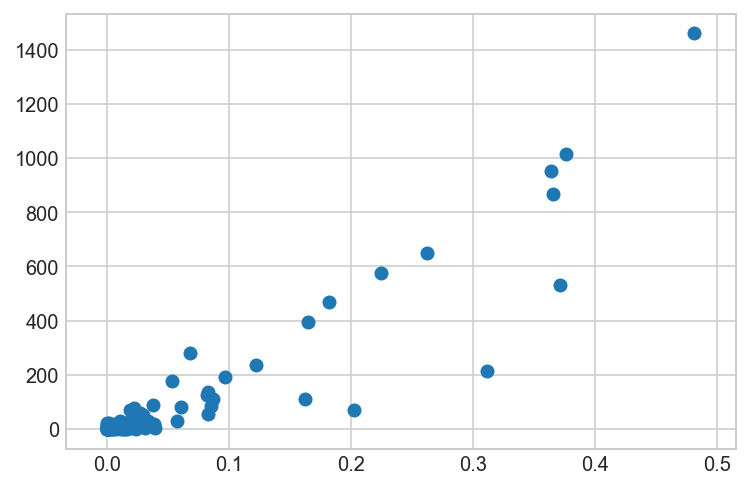

In [32]:
#Plot the Feature Scores using log function
plt.scatter(kbest['MIR'], kbest['FRG'])

In [33]:
# Feature testing using RFECV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X, y)

print(selector.support_)
print(selector.ranking_)

[False False False  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[4 5 2 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [34]:
# Use the all of the features:
# Split the Train and Test data by Year Sold
X_Train = df_house_m1[df_house_m1['YrSold'] != 2010][cols]
y_Train = df_house_m1[df_house_m1['YrSold'] != 2010]['SalePrice'].values

X_Test = df_house_m1[df_house_m1['YrSold'] == 2010][cols]
y_Test = df_house_m1[df_house_m1['YrSold'] == 2010]['SalePrice'].values

In [35]:
# Perform Scaling first before doing MLR Model
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.fit_transform(X_Test)

In [36]:
# Convert the Scaled Values into DataFrame to preserve the column names during the model creation
X_Train = pd.DataFrame(data=X_Train, columns=cols)
X_Test = pd.DataFrame(data=X_Test, columns=cols)

In [37]:
#Build the Regression Model using MLR using sklearn
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model = lm.fit(X_Train, y_Train)

In [38]:
model.score(X_Train, y_Train)

0.832074786872669

In [39]:
model.score(X_Test, y_Test)

0.8444492215923947

In [40]:
#Build the Regression Model using MLR using statsmodel
X_Train = sm.add_constant(X_Train)
model = sm.OLS(y_Train, X_Train).fit() 

In [41]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     60.96
Date:                Thu, 11 Oct 2018   Prob (F-statistic):               0.00
Time:                        22:02:46   Log-Likelihood:                -15087.
No. Observations:                1278   AIC:                         3.037e+04
Df Residuals:                    1181   BIC:                         3.087e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  1.82e+05    942.782    193.035      0.000     1.8e+05    1.84e+05
LotFrontage           -735.2084   1159.714     -0.634      0.526   -3010.538    1540.121
LotArea               5479.6440   1471.421      3.724      0.000    2592.753    8366.535
TotalBsmtSF           2863.8769   2006.379      1.427      0.154   -1072.587    6800.341
GrLivArea             3.551e+04   2987.648     11.885      0.000    2.96e+04    4.14e+04
BsmtFullBath          7102.6093   1142.797      6.215      0.000    4860.471    9344.747
BsmtHalfBath          2993.3569   1030.527      2.905      0.004     971.489    5015.225
FullBath              3791.9076   1764.261      2.149      0.032     330.471    7253.344
HalfBath              4234.7155   1556.026      2.721      0.007    1181.833    7287.598
KitchenAbvGr         -7057.8958   1799.937     -3.921      0.000   -1.06e+04   -3526.464
TotRmsAbvGrd           913.6818   2052.765      0.445      0.656   -3113.791    4941.155
Fireplaces            4962.0730   1242.506      3.994      0.000    2524.308    7399.838
GarageCars            1.114e+04   2397.150      4.649      0.000    6441.482    1.58e+04
GarageArea           -2367.2990   2328.230     -1.017      0.309   -6935.227    2200.629
Age                  -1.108e+04   3234.089     -3.425      0.001   -1.74e+04   -4731.587
Remodel               2876.3171   1166.348      2.466      0.014     587.973    5164.662
AgeGarage            -3485.9457   1490.395     -2.339      0.020   -6410.062    -561.829
MSSubClass_30         -276.1122   1452.642     -0.190      0.849   -3126.160    2573.936
MSSubClass_40          -85.6408    997.105     -0.086      0.932   -2041.935    1870.653
MSSubClass_45        -1291.8479   2704.903     -0.478      0.633   -6598.800    4015.104
MSSubClass_50        -1921.0335   3837.090     -0.501      0.617   -9449.308    5607.241
MSSubClass_60        -7364.2640   4579.246     -1.608      0.108   -1.63e+04    1620.101
MSSubClass_70         -761.9397   2419.022     -0.315      0.753   -5508.000    3984.120
MSSubClass_75        -2126.6869   2439.615     -0.872      0.384   -6913.150    2659.776
MSSubClass_80        -3125.7547   3576.860     -0.874      0.382   -1.01e+04    3891.955
MSSubClass_85        -1106.2909   1763.761     -0.627      0.531   -4566.746    2354.164
MSSubClass_90         -951.4535    915.576     -1.039      0.299   -2747.790     844.883
MSSubClass_120       -8490.1514   4990.962     -1.701      0.089   -1.83e+04    1301.989
MSSubClass_160       -1.177e+04   5103.886     -2.306      0.021   -2.18e+04   -1754.635
MSSubClass_180       -2478.2312   2370.377     -1.046      0.296   -7128.851    2172.389
MSSubClass_190        1306.9475   5028.469      0.260      0.795   -8558.782    1.12e+04
MSZoning_RH           -869.7987   1492.717     -0.583    

In [42]:
#Get list of p_values and remove the first one which corresponds to the intercept (const)
p_values = list(model.pvalues)
p_values.pop(0)

#Build DataFrame using the p_values and column names as the index
df_features_p = pd.DataFrame(data=p_values, columns=['p_value'], index=cols)

In [43]:
#Filter DataFrame with p_values <= 0.05
print(df_features_p[df_features_p['p_value'] <= 0.05].shape)
print(df_features_p[df_features_p['p_value'] <= 0.05].index.values)

(27, 1)
['LotArea' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'KitchenAbvGr' 'Fireplaces' 'GarageCars' 'Age' 'Remodel' 'AgeGarage'
 'MSSubClass_160' 'LotShape_IR3' 'LandContour_HLS' 'LandContour_Lvl'
 'LotConfig_CulDSac' 'LandSlope_Sev' 'Neighborhood_Edwards'
 'Neighborhood_Gilbert' 'Neighborhood_Mitchel' 'Neighborhood_NWAmes'
 'Neighborhood_NoRidge' 'Neighborhood_NridgHt' 'Neighborhood_StoneBr'
 'Condition1_Feedr' 'Condition1_RRAe']


In [44]:
#Filter DataFrame with p_values <= 0.05
df_features_p[df_features_p['p_value'] <= 0.05].sort_values(by='p_value', ascending=True)

,p_value
GrLivArea,7.536246e-31
BsmtFullBath,7.098744e-10
Neighborhood_NridgHt,1.071001e-09
Neighborhood_StoneBr,5.649678e-08
GarageCars,3.708667e-06
Fireplaces,6.909657e-05
KitchenAbvGr,9.318288e-05
Neighborhood_NoRidge,1.171291e-04
LotArea,2.053039e-04
LandContour_HLS,2.910657e-04


In [45]:
#Drop p values > 0.05
df_features_p = df_features_p[df_features_p['p_value'] <= 0.05]

In [46]:
#Readjust the Model using the reduced number of features based on p_value <= 0.05
X_Train = df_house_m1[df_house_m1['YrSold'] != 2010][df_features_p.index.values]
y_Train = df_house_m1[df_house_m1['YrSold'] != 2010]['SalePrice'].values

X_Test = df_house_m1[df_house_m1['YrSold'] == 2010][df_features_p.index.values]
y_Test = df_house_m1[df_house_m1['YrSold'] == 2010]['SalePrice'].values

In [47]:
ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.transform(X_Test)

In [48]:
X_Train = pd.DataFrame(data=X_Train, columns=df_features_p.index.values)
X_Test = pd.DataFrame(data=X_Test, columns=df_features_p.index.values)

In [49]:
X_Train = sm.add_constant(X_Train)
model = sm.OLS(y_Train, X_Train).fit() 

In [50]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     187.1
Date:                Thu, 11 Oct 2018   Prob (F-statistic):               0.00
Time:                        22:02:46   Log-Likelihood:                -15193.
No. Observations:                1278   AIC:                         3.044e+04
Df Residuals:                    1250   BIC:                         3.059e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  1.82e+05    995.932    182.733      0.000     1.8e+05    1.84e+05
LotArea               7247.0518   1359.749      5.330      0.000    4579.409    9914.694
GrLivArea             3.381e+04   1821.351     18.564      0.000    3.02e+04    3.74e+04
BsmtFullBath          7088.6982   1097.845      6.457      0.000    4934.876    9242.520
BsmtHalfBath          2276.2811   1031.638      2.206      0.028     252.348    4300.214
FullBath              3262.4218   1671.789      1.951      0.051     -17.400    6542.243
HalfBath              -316.0259   1291.074     -0.245      0.807   -2848.937    2216.885
KitchenAbvGr         -8080.8682   1083.836     -7.456      0.000   -1.02e+04   -5954.531
Fireplaces            6275.6181   1210.809      5.183      0.000    3900.176    8651.060
GarageCars            1.237e+04   1393.339      8.879      0.000    9637.566    1.51e+04
Age                  -1.589e+04   1897.139     -8.377      0.000   -1.96e+04   -1.22e+04
Remodel               4271.5724   1148.486      3.719      0.000    2018.400    6524.745
AgeGarage            -4649.1954   1428.864     -3.254      0.001   -7452.433   -1845.958
MSSubClass_160       -6578.6215   1080.008     -6.091      0.000   -8697.450   -4459.793
LotShape_IR3         -3264.0621   1053.711     -3.098      0.002   -5331.300   -1196.824
LandContour_HLS       4223.4476   1247.823      3.385      0.001    1775.390    6671.505
LandContour_Lvl       1767.1366   1302.881      1.356      0.175    -788.938    4323.211
LotConfig_CulDSac     3088.0491   1042.370      2.963      0.003    1043.061    5133.038
LandSlope_Sev        -3142.7888   1246.265     -2.522      0.012   -5587.791    -697.787
Neighborhood_Edwards -4744.9833   1040.840     -4.559      0.000   -6786.969   -2702.997
Neighborhood_Gilbert -5415.6940   1118.731     -4.841      0.000   -7610.492   -3220.895
Neighborhood_Mitchel -3520.9600   1033.584     -3.407      0.001   -5548.711   -1493.209
Neighborhood_NWAmes  -3637.6206   1060.814     -3.429      0.001   -5718.793   -1556.448
Neighborhood_NoRidge  7872.7732   1092.839      7.204      0.000    5728.772       1e+04
Neighborhood_NridgHt  1.374e+04   1119.328     12.278      0.000    1.15e+04    1.59e+04
Neighborhood_StoneBr  8008.1384   1036.653      7.725      0.000    5974.366       1e+04
Condition1_Feedr     -3504.4003   1020.629     -3.434      0.001   -5506.736   -1502.065
Condition1_RRAe      -2552.1028   1009.377     -2.528      0.012   -4532.362    -571.844
==============================================================================
Omnibus:                      323.710   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11973.777
Skew:                           0.418   Prob(JB):                         0.00
Kurtosis

In [51]:
#Do Feature Selection using Lasso
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [52]:
alphas = 10**np.linspace(10,-2,100)*0.5

In [53]:
# Use the all of the features:
# Split the Train and Test data by Year Sold
X_Train = df_house_m1[df_house_m1['YrSold'] != 2010][cols]
y_Train = df_house_m1[df_house_m1['YrSold'] != 2010]['SalePrice'].values

X_Test = df_house_m1[df_house_m1['YrSold'] == 2010][cols]
y_Test = df_house_m1[df_house_m1['YrSold'] == 2010]['SalePrice'].values

Text(0,0.5,'weights')

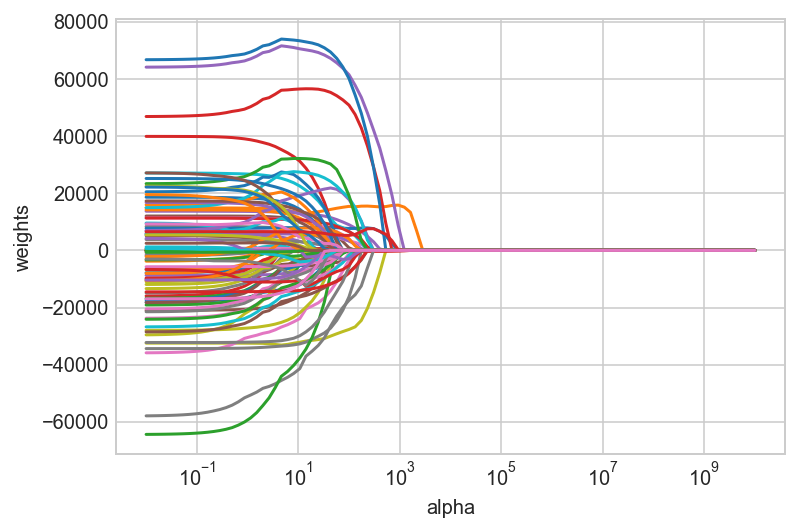

In [54]:
lasso = Lasso(max_iter = 100000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_Train, y_Train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [55]:
y_Test.shape, X_Test.shape

((172,), (172, 97))

In [56]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_Train, y_Train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_Train, y_Train)
#mean_squared_error(y_Test, lasso.predict(X_Test))

Lasso(alpha=18.008724088583946, copy_X=True, fit_intercept=True,
   max_iter=100000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [57]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_)

0         0.000000
1         0.354437
2        15.585191
3        58.850314
4     11858.167331
5      7714.485104
6      5609.693074
7      2773.498451
8    -30610.957394
9       421.220890
10     8009.478045
11    14039.364320
12        0.000000
13     -381.242434
14     5237.590922
15     -119.681122
16       -0.000000
17        0.000000
18        0.000000
19    -4372.781722
20    -3794.693001
21        0.000000
22       -0.000000
23        0.000000
24        0.000000
25    -4587.189419
26   -15880.114855
27   -29435.523296
28       -0.000000
29        0.000000
          ...     
67    -3223.681987
68        0.000000
69    25039.222264
70    70483.266023
71     7386.901882
72    30805.788012
73   -12206.736483
74     5955.533302
75     8704.983288
76    -3232.698537
77   -20388.654832
78        0.000000
79       -0.000000
80     7977.588979
81       -0.000000
82     -736.784526
83    -9197.571754
84    -1760.370603
85     2608.528184
86     2319.288102
87    -2388.516528
88        0.

In [58]:
lasso.score(X_Train, y_Train)

0.8242583172338768

In [59]:
X_Train.shape, y_Train.shape, X_Test.shape, y_Test.shape

((1278, 97), (1278,), (172, 97), (172,))

In [60]:
lasso.score(X_Test, y_Test)

0.8412504032519726

In [61]:
#reminders
#dont forget to plot the residuals

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [62]:
# A:
# try seting target variable = residuals
# then do a model that fits the new target variable 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

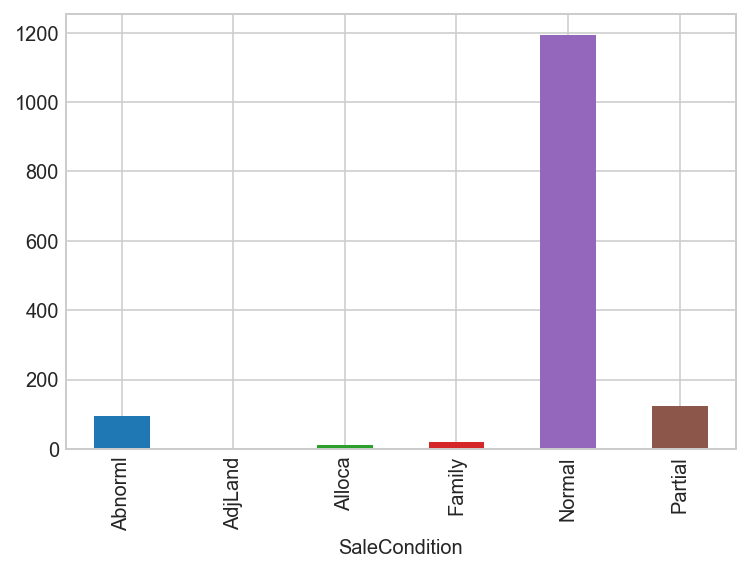

In [63]:
# A:
t = df_house_res.groupby('SaleCondition').count()
t['SalePrice'].plot(kind='bar')

In [64]:
df_experiment = df_house_res.copy()

In [65]:
df_experiment = pd.get_dummies(data=df_experiment, columns=['SaleCondition'], drop_first=True)

In [66]:
df_experiment_corr = df_experiment.corr()

In [67]:
df_experiment_corr.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object')

In [68]:
df_experiment_corr[['SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial']].sort_values(by='SaleCondition_Family', ascending=False)

,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
SaleCondition_Family,-0.006220,-0.010340,1.000000,-0.255405,-0.036324
BedroomAbvGr,0.040666,0.033440,0.062395,0.010679,-0.059722
KitchenAbvGr,-0.011068,0.234999,0.055905,-0.050836,-0.042256
BsmtHalfBath,0.097776,-0.021013,0.046060,-0.017818,-0.042869
TotRmsAbvGrd,-0.008807,0.074638,0.031148,-0.101695,0.141768
LotFrontage,-0.004607,-0.011665,0.028826,-0.133606,0.185237
GarageYrBlt,-0.162073,-0.014618,0.025909,0.023269,0.070438
BsmtUnfSF,-0.034697,-0.061389,0.021538,-0.154112,0.249754
1stFlrSF,-0.037866,0.073301,0.021365,-0.168412,0.220130
TotalBsmtSF,-0.056261,-0.040216,0.019081,-0.168469,0.265582


In [69]:
df_house_res[df_house_res['SaleCondition'] == 'Abnorml']

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
8,9,50,RM,51.0,6120,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2008,WD,Abnorml,129900
19,20,20,RL,70.0,7560,Pave,NA,Reg,Lvl,AllPub,...,0,NA,MnPrv,NA,0,5,2009,COD,Abnorml,139000
38,39,20,RL,68.0,7922,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,1,2010,WD,Abnorml,109000
40,41,20,RL,84.0,8658,Pave,NA,Reg,Lvl,AllPub,...,0,NA,GdWo,NA,0,12,2006,WD,Abnorml,160000
46,47,50,RL,48.0,12822,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,8,2009,WD,Abnorml,239686
56,57,160,FV,24.0,2645,Pave,Pave,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,8,2009,WD,Abnorml,172500
91,92,20,RL,85.0,8500,Pave,NA,Reg,Lvl,AllPub,...,0,NA,GdWo,NA,0,12,2006,WD,Abnorml,98600
98,99,30,RL,85.0,10625,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,Shed,400,5,2010,COD,Abnorml,83000
113,114,20,RL,0.0,21000,Pave,NA,Reg,Bnk,AllPub,...,0,NA,MnPrv,NA,0,10,2007,COD,Abnorml,217000


In [70]:
df_house_res[df_house_res['SaleCondition'] == 'Family']

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
137,138,90,RL,82.0,11070,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,7,2006,WD,Family,171000
154,155,30,RM,84.0,11340,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,3,2006,WD,Family,125000
217,218,70,RM,57.0,9906,Pave,Grvl,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,9,2006,WD,Family,107000
251,252,120,RM,44.0,4750,Pave,NA,IR1,HLS,AllPub,...,0,NA,NA,NA,0,12,2007,WD,Family,235000
299,300,20,RL,80.0,14000,Pave,NA,Reg,Lvl,AllPub,...,0,NA,GdPrv,NA,0,8,2009,WD,Family,158500
454,455,90,RL,63.0,9297,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,7,2006,WD,Family,188000
628,629,60,RL,70.0,11606,Pave,NA,IR1,HLS,AllPub,...,0,NA,NA,NA,0,9,2007,WD,Family,135000
632,633,20,RL,85.0,11900,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2009,WD,Family,82500
655,656,160,RM,21.0,1680,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,3,2010,WD,Family,88000
734,735,20,RL,0.0,8978,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Family,108000
